In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u

In [21]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
def get_lbl_name(name):
    if name == 'hot': lbl_name = 'hot ($>10^6$ K)'
    elif name == 'warmhot': lbl_name = 'warm-hot ($10^5-10^6$ K)'
    elif name == 'warm': lbl_name = r'warm ($1.5\times 10^4-10^5$ K)'
    elif name == 'cold': lbl_name = r'cold ($<1.5\times 10^4$ K)'
    elif name == 'stars': lbl_name = 'stars'
    elif name == 'dm': lbl_name = 'dark matter'

    return lbl_name



In [19]:
all_rprof_halos = {}
for halo in ['5016', '8508', '5036', '4123', '2392', '2878']:
    print (halo)
    profdir = '/Users/rsimons/Dropbox/foggie/angular_momentum/profiles/%s'%halo
    all_rprof_fname = profdir + '/' + 'all_rprof_%s.npy'%halo
    all_rprof_halos[halo] = np.load(all_rprof_fname, allow_pickle = True)[()]


5016
8508
5036
4123
2392
2878


<ipython-input-81-0a353ddec48b>:52: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('symlog', linthreshx=30)
<ipython-input-81-0a353ddec48b>:91: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('symlog', linthreshx=30)
<ipython-input-81-0a353ddec48b>:52: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('symlog', linthreshx=30)
<ipython-input-81-0a353ddec48b>:91: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two

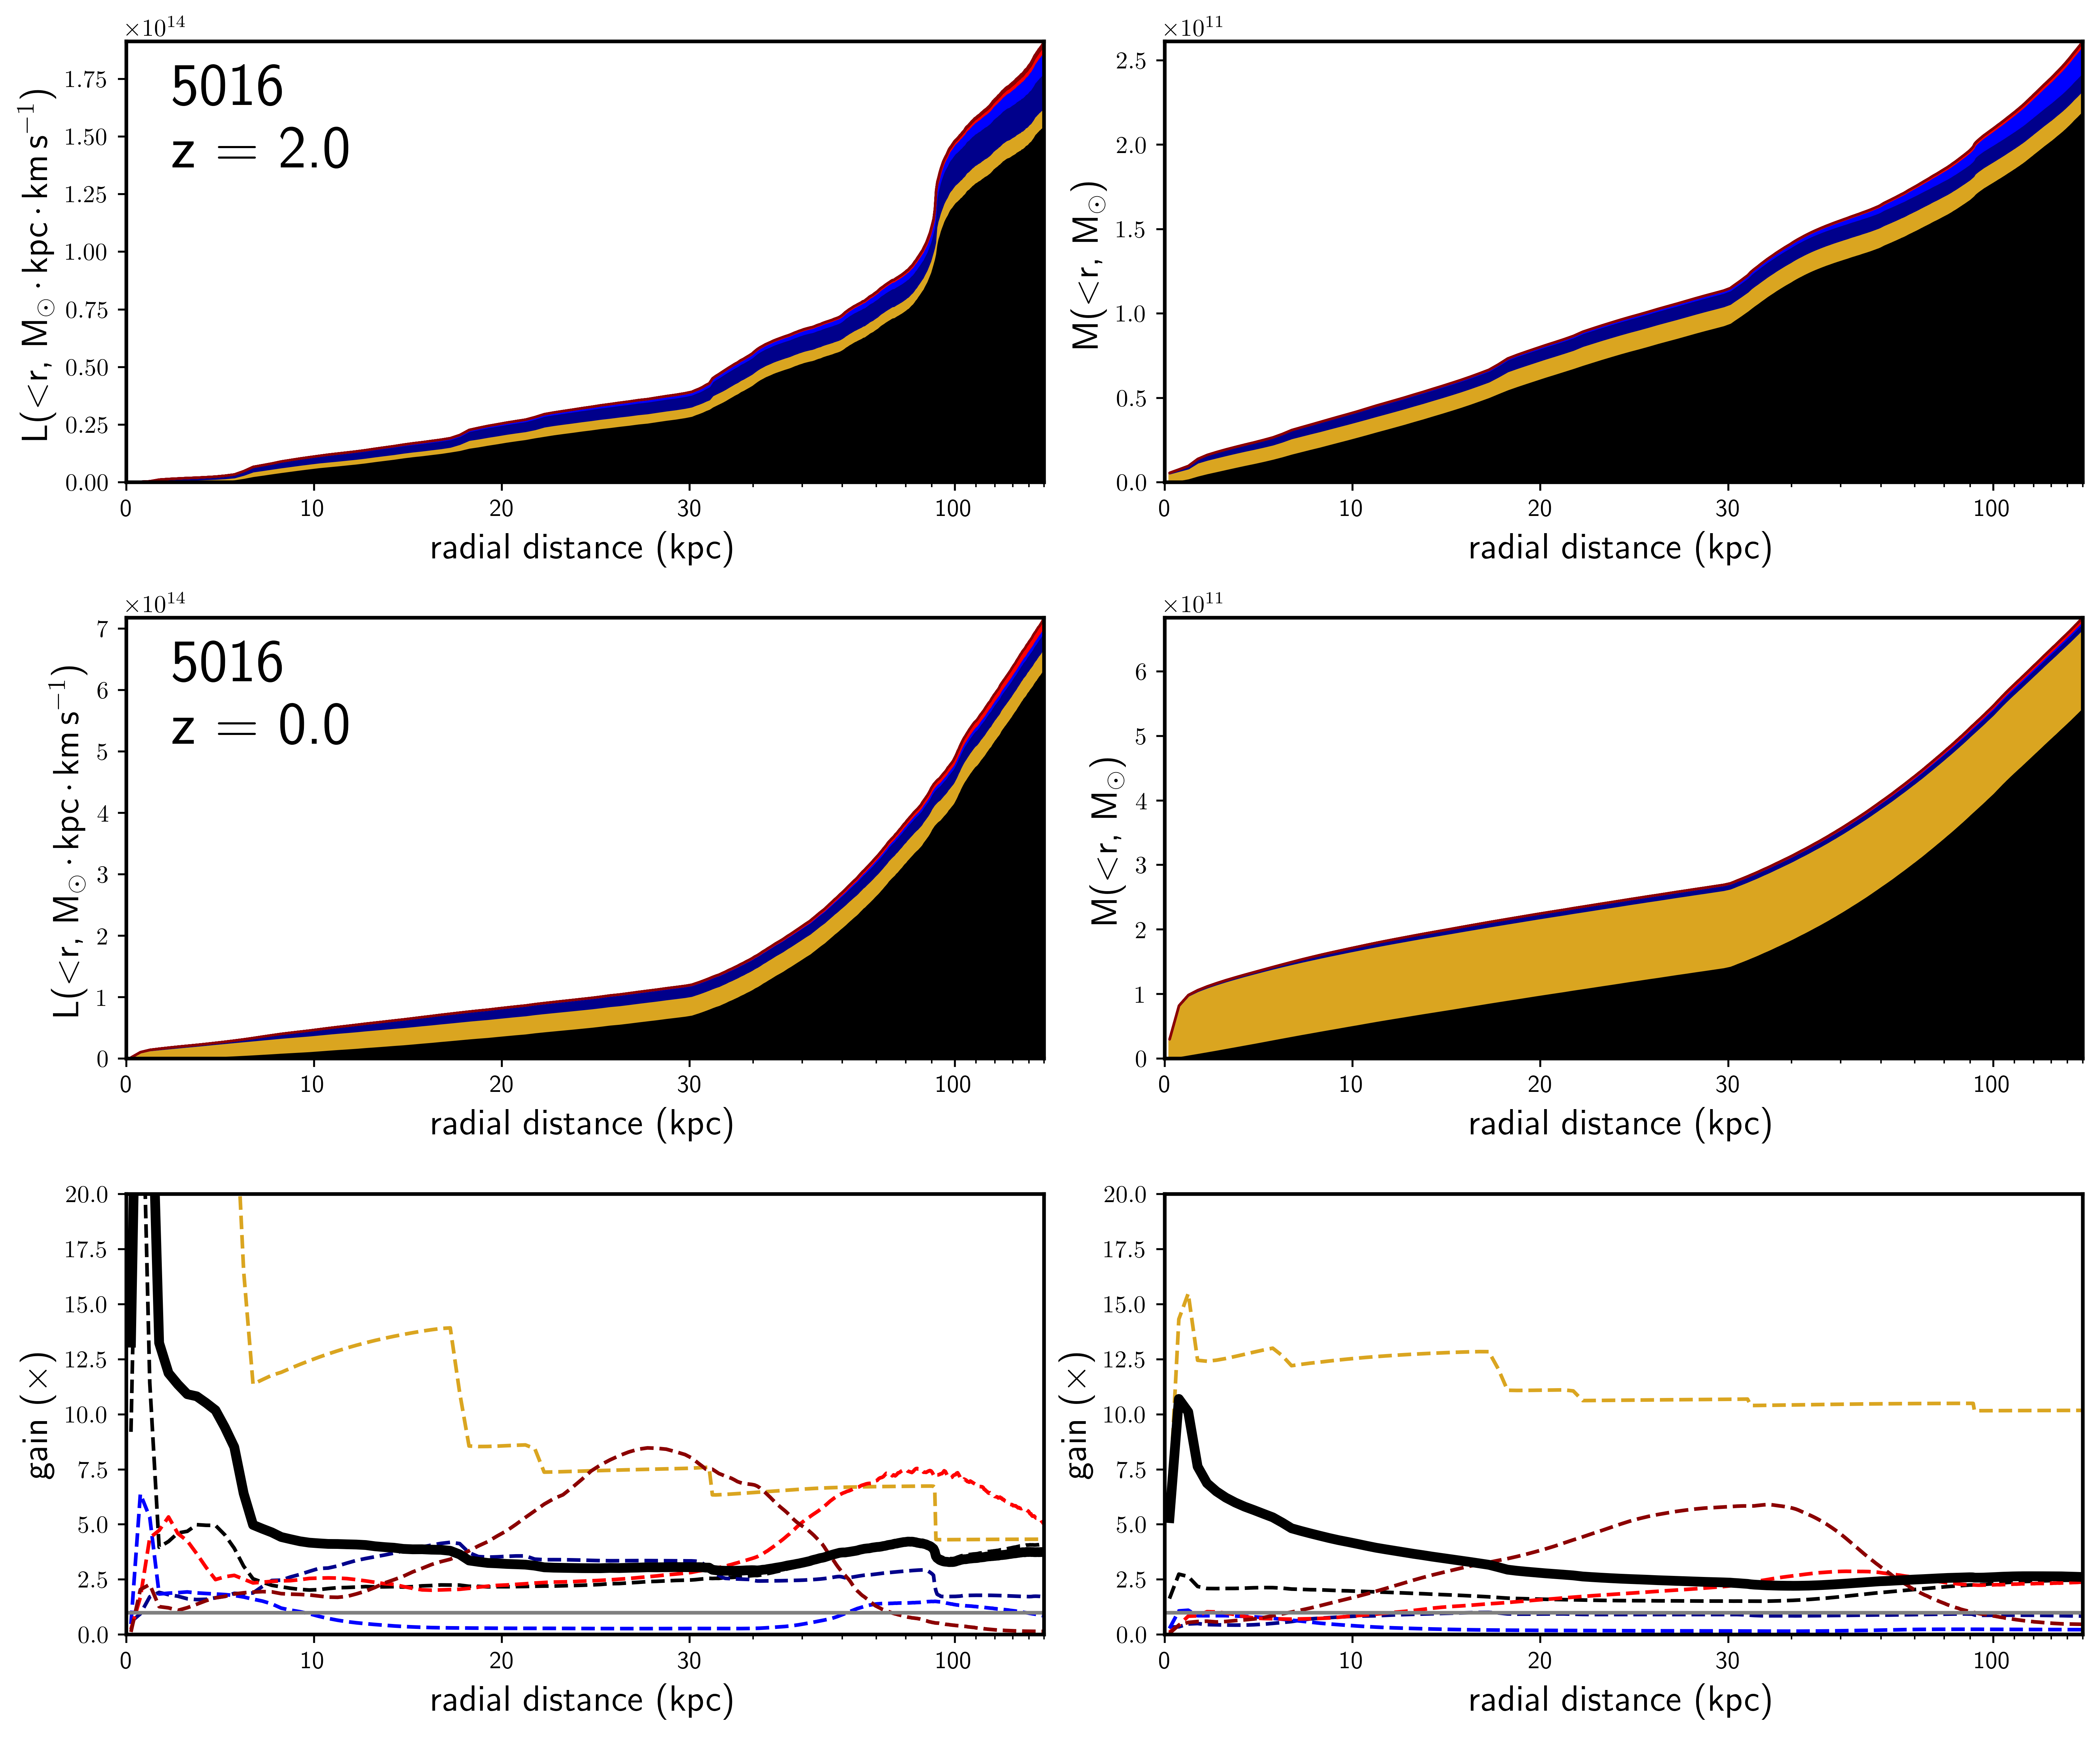

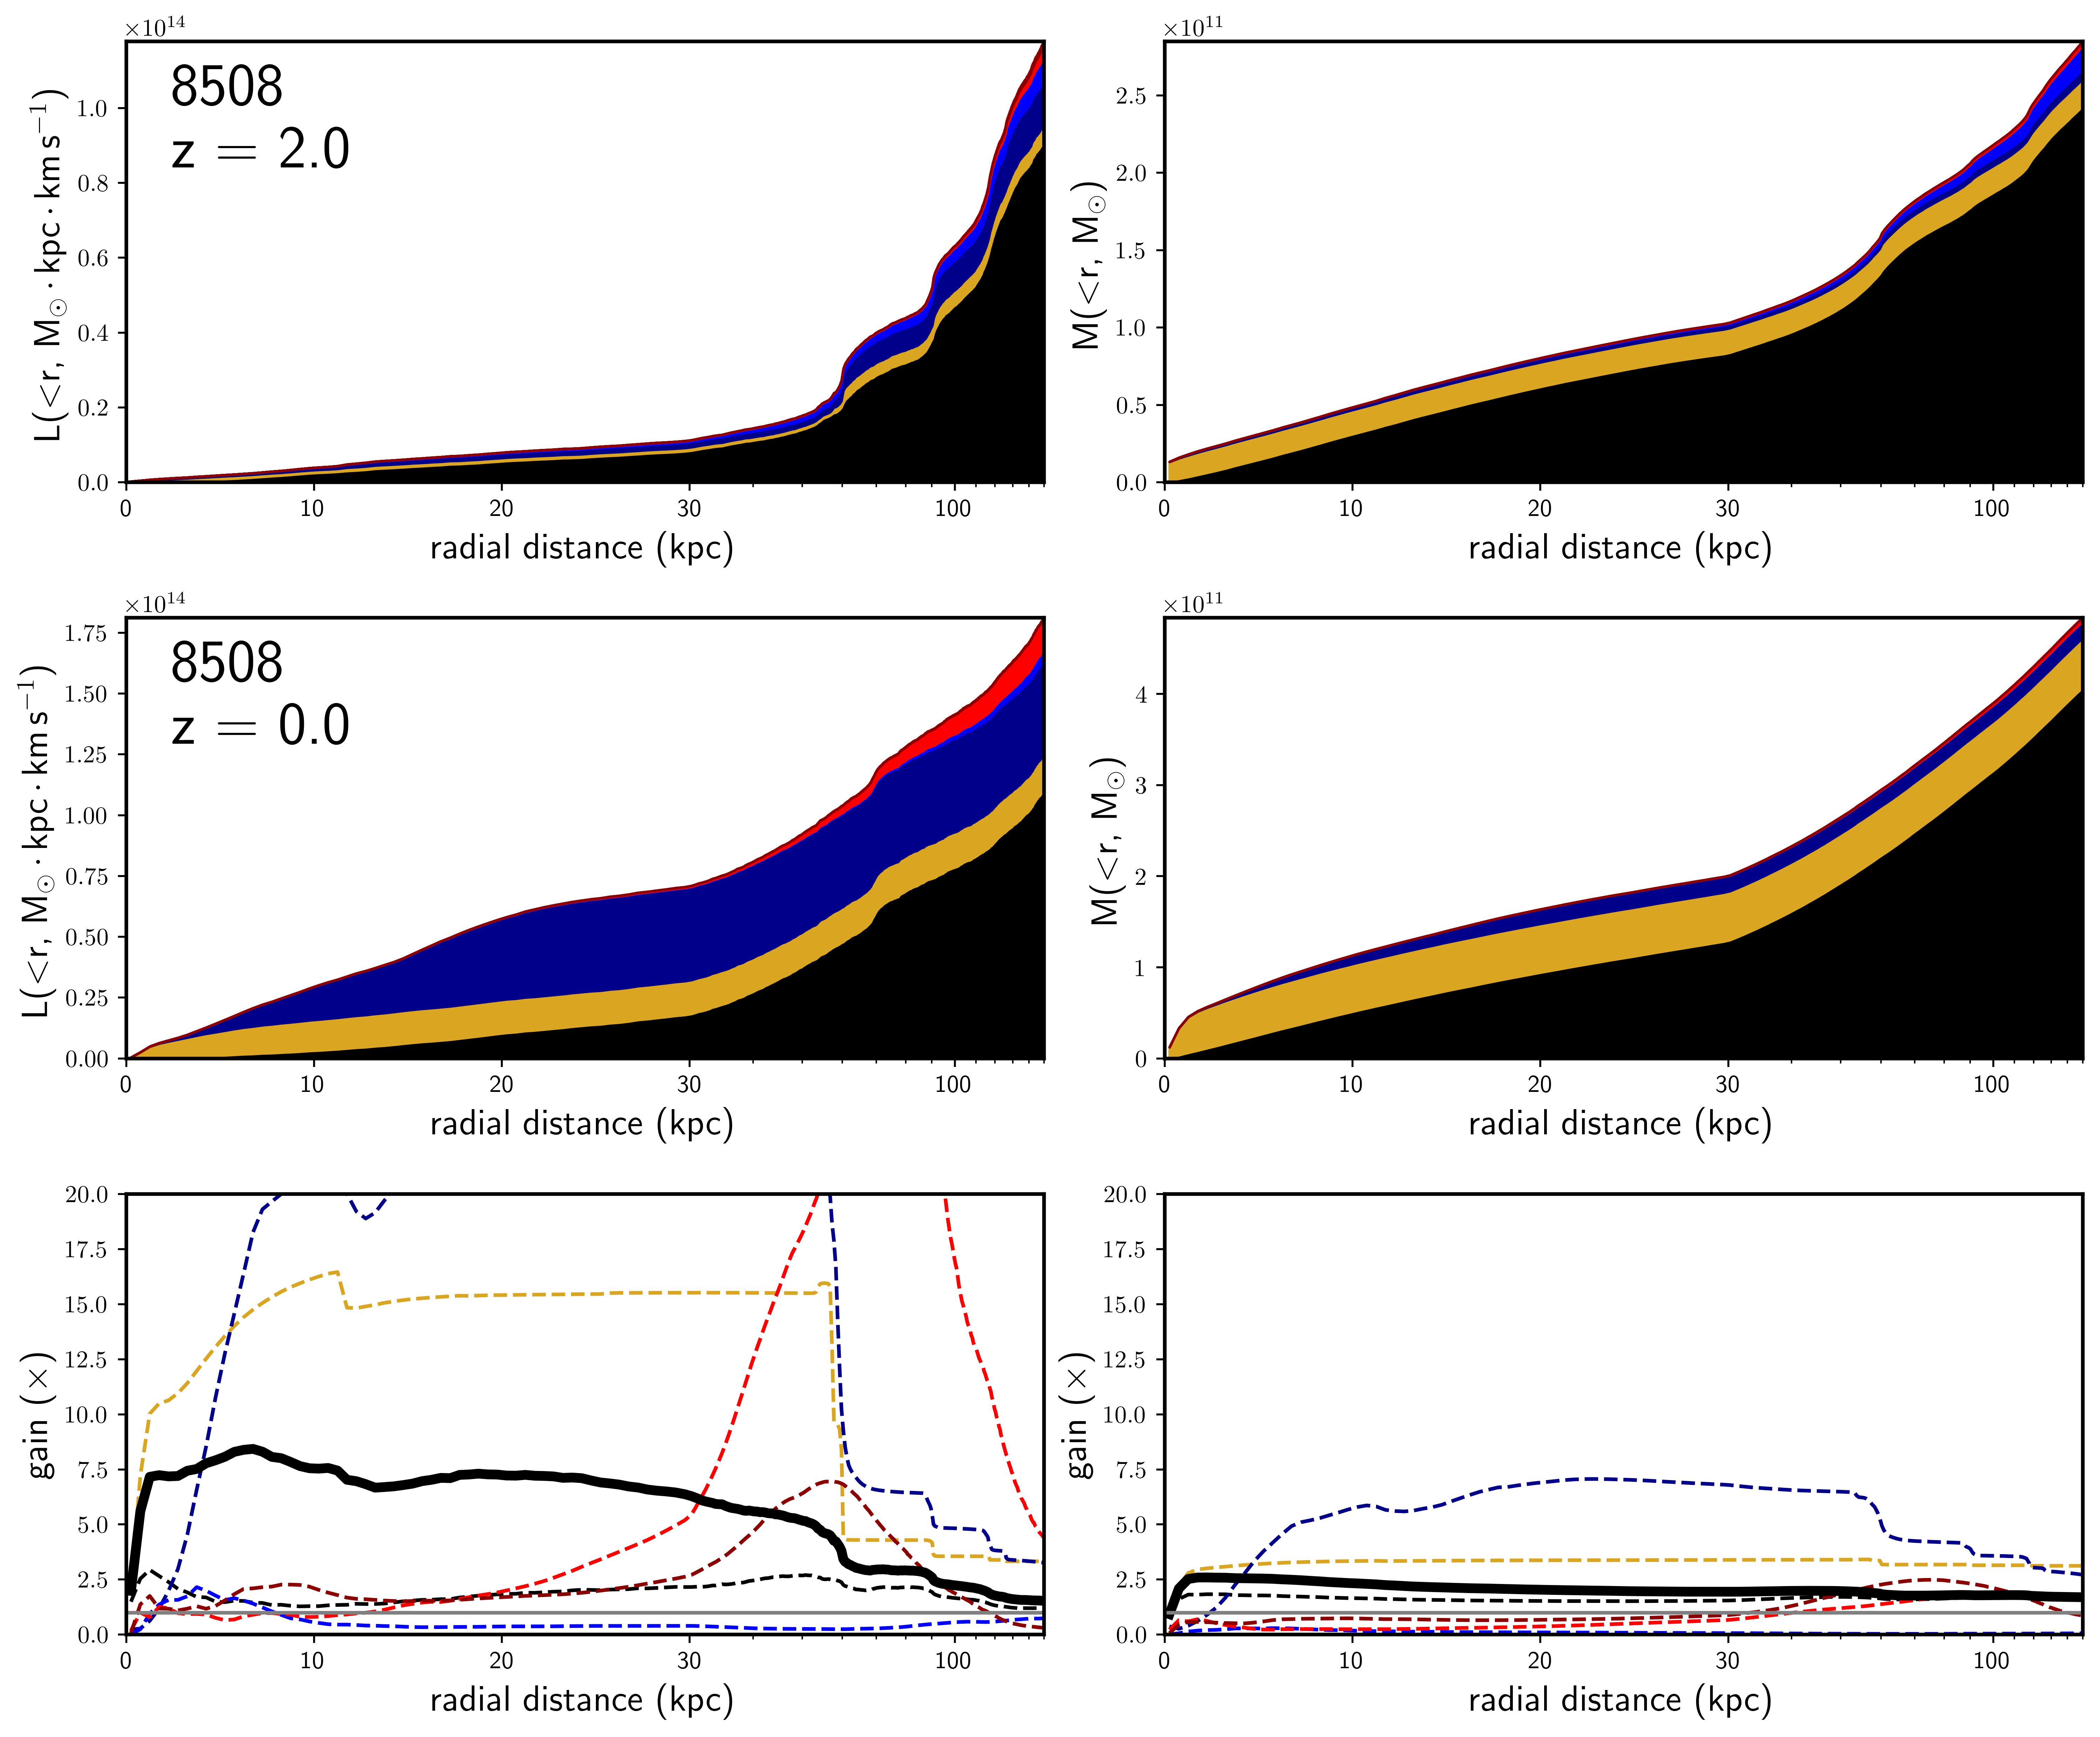

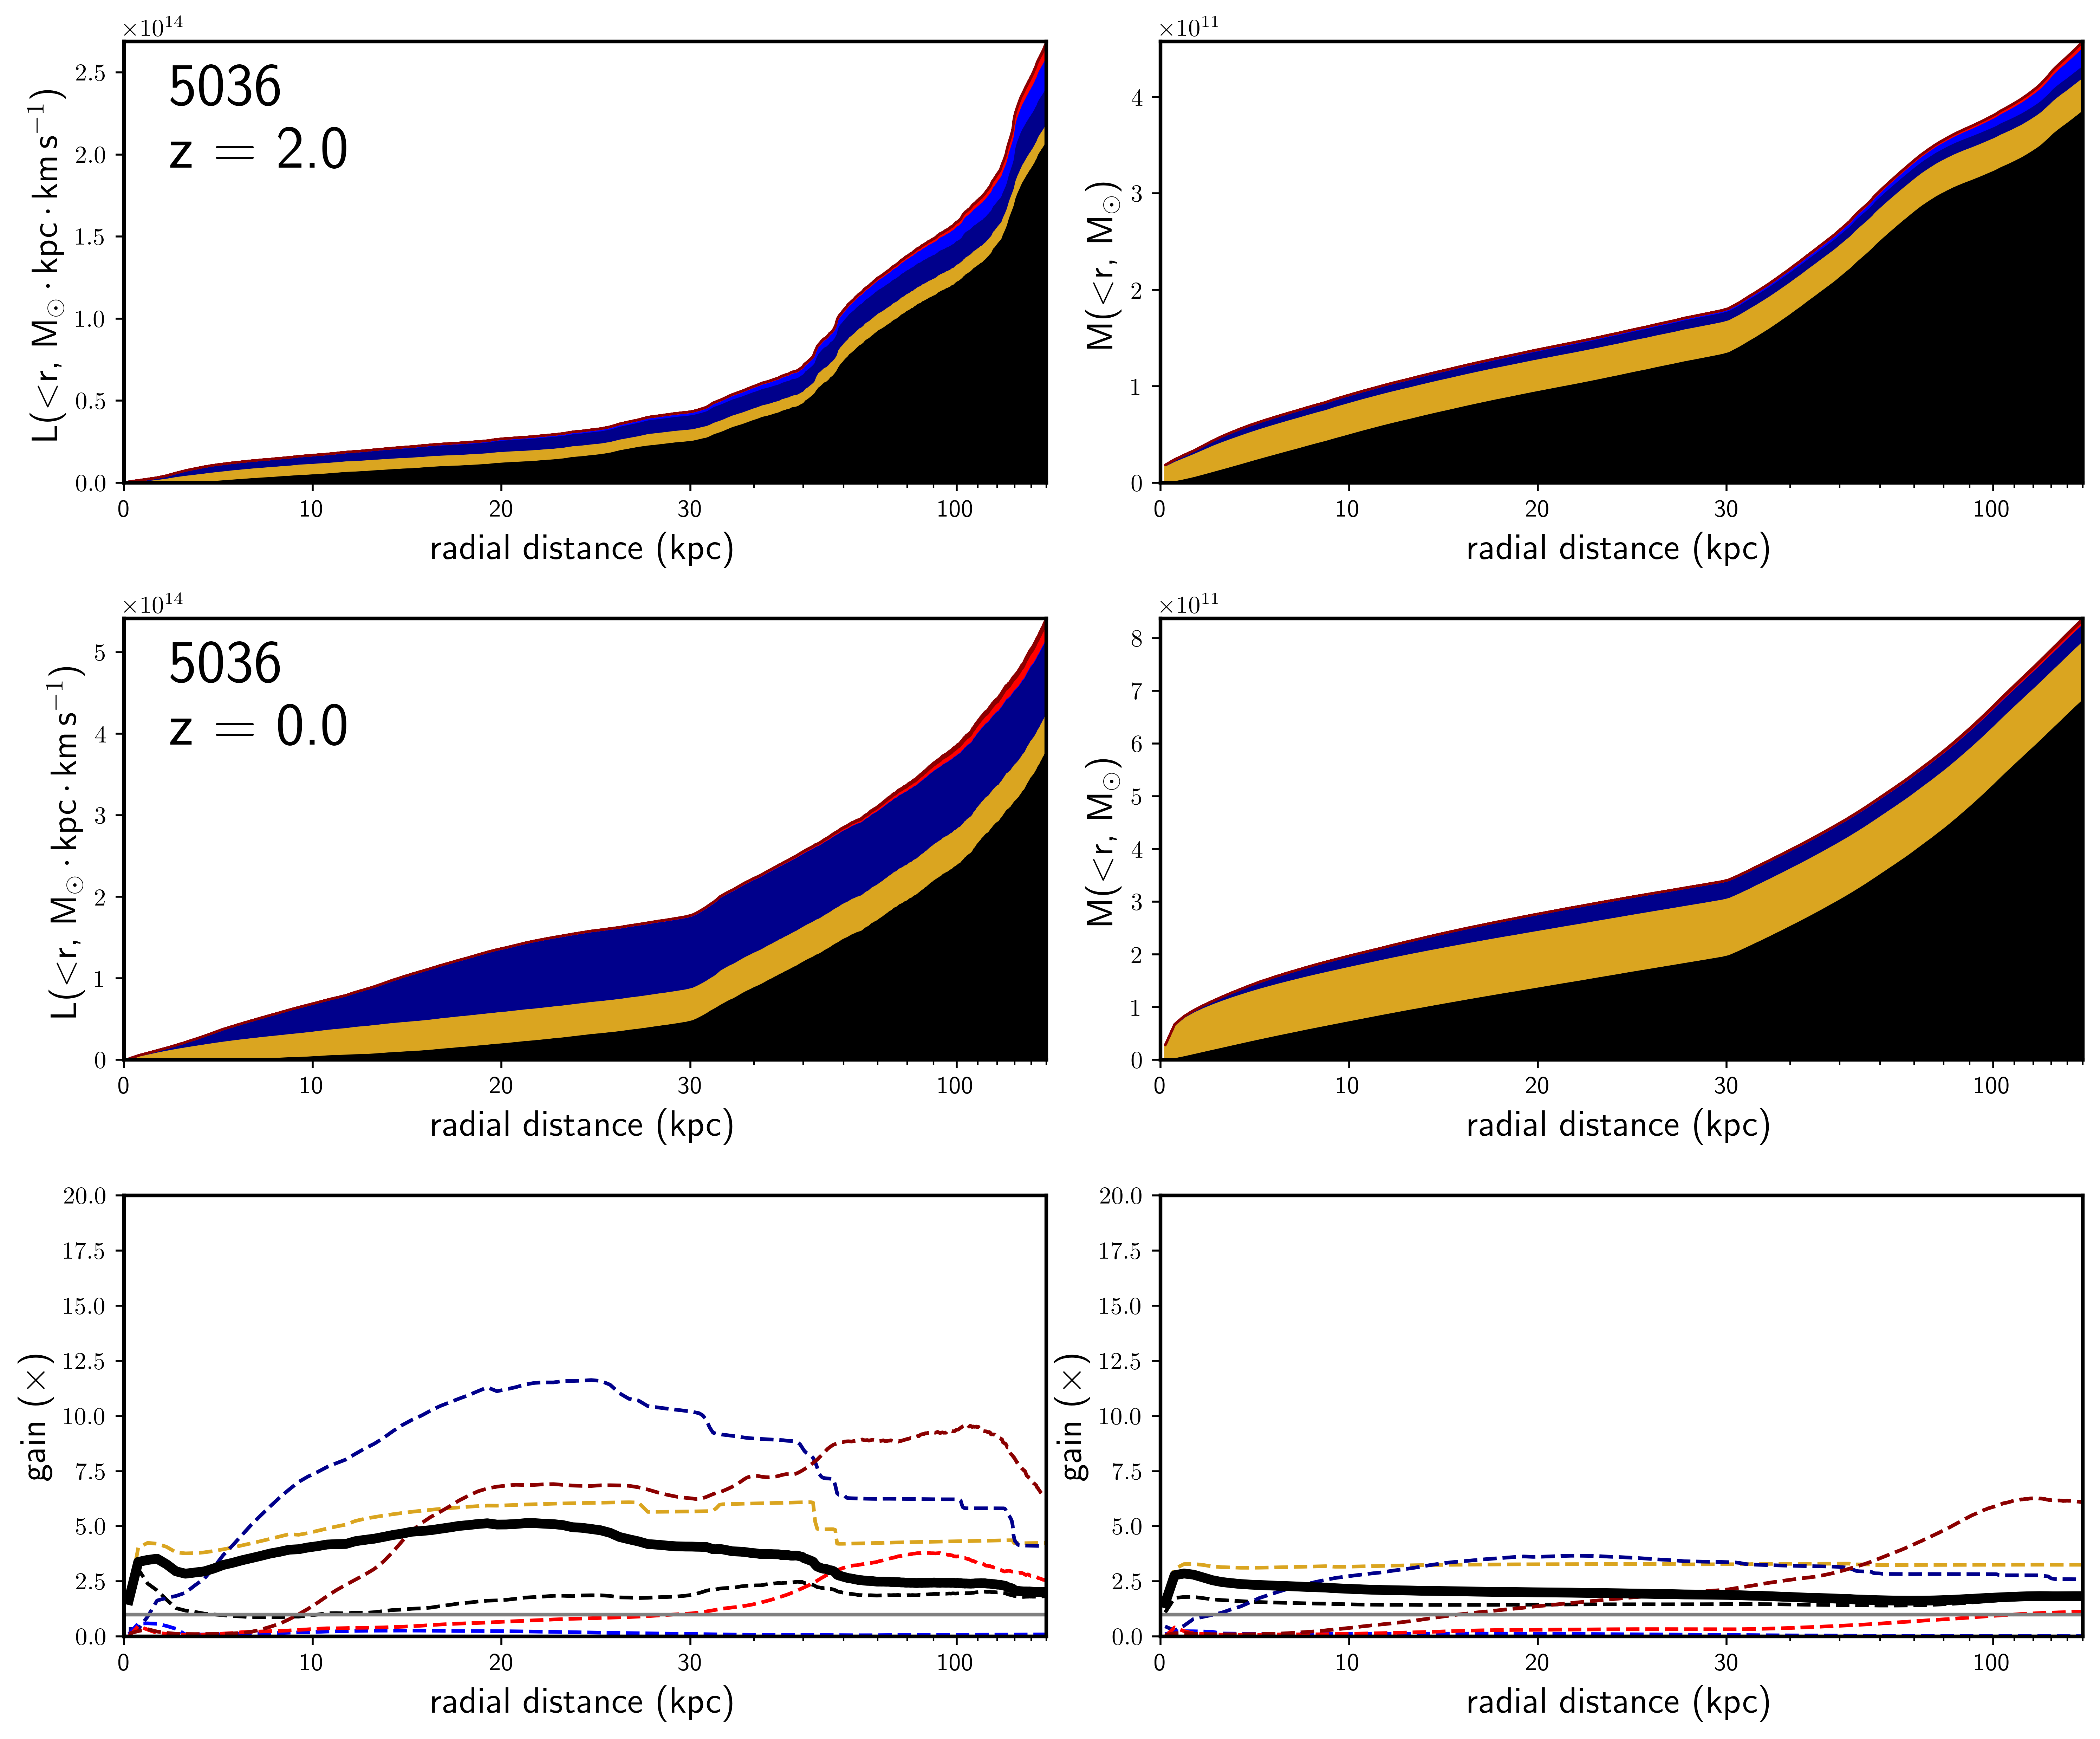

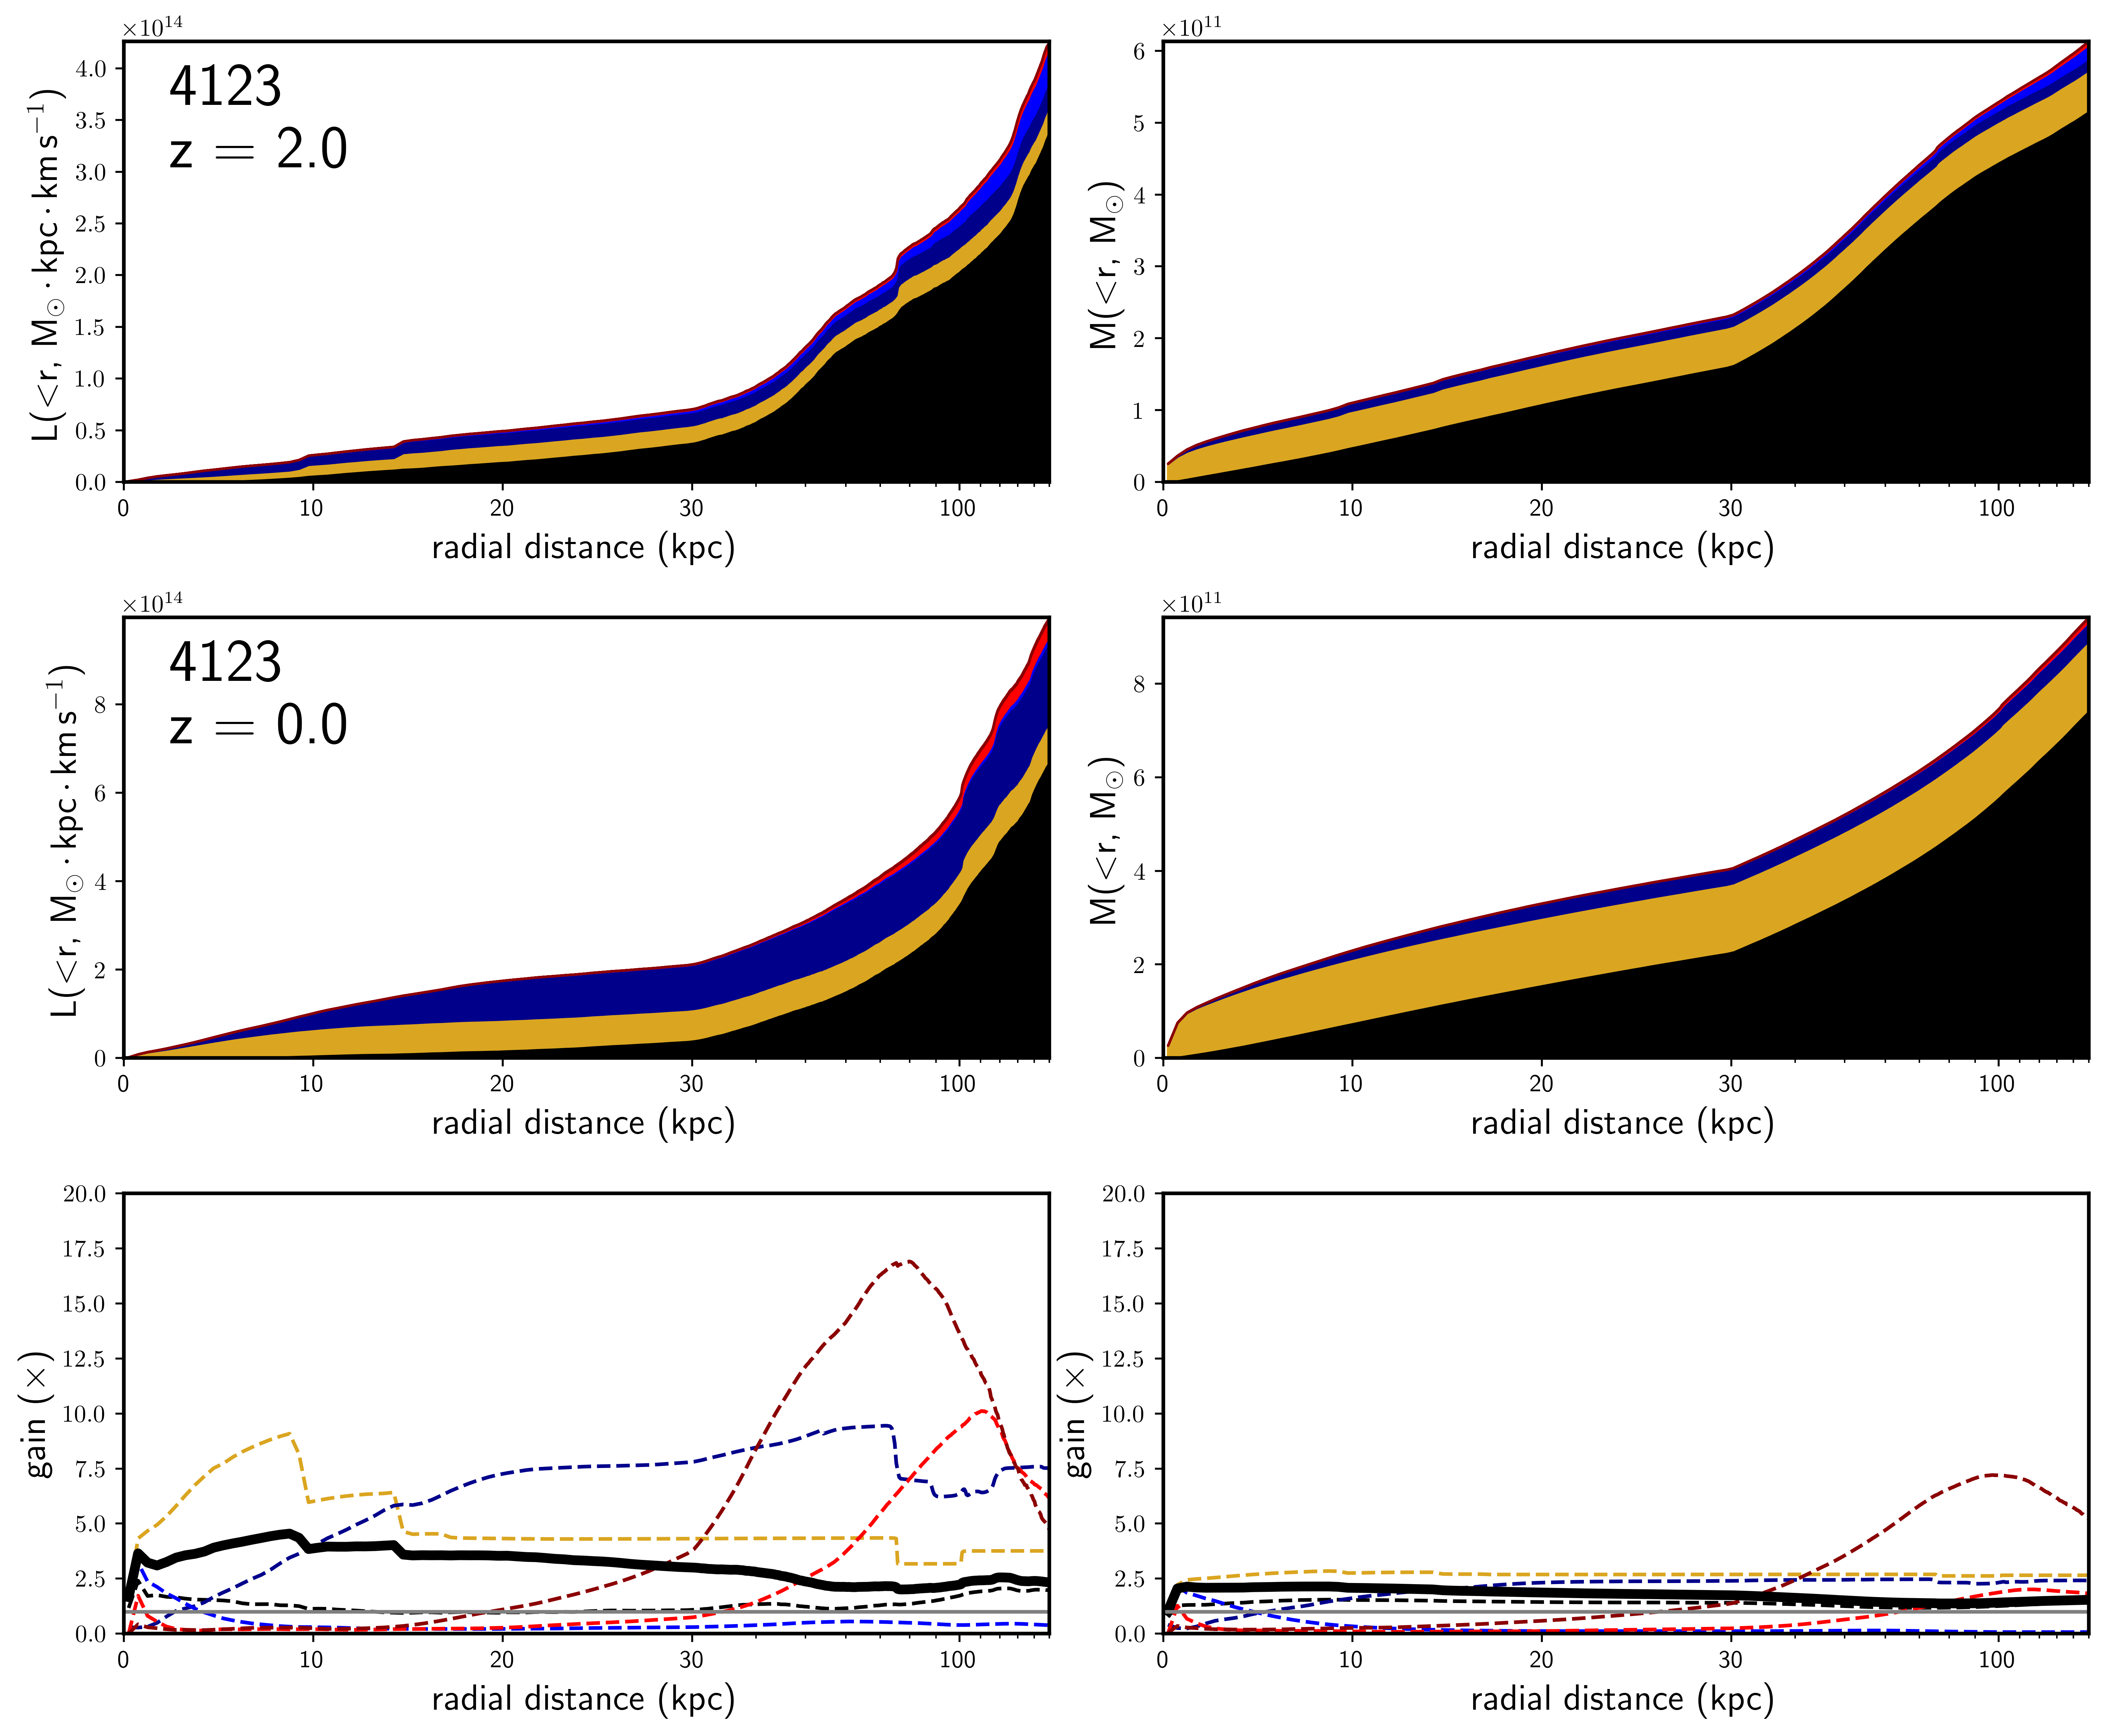

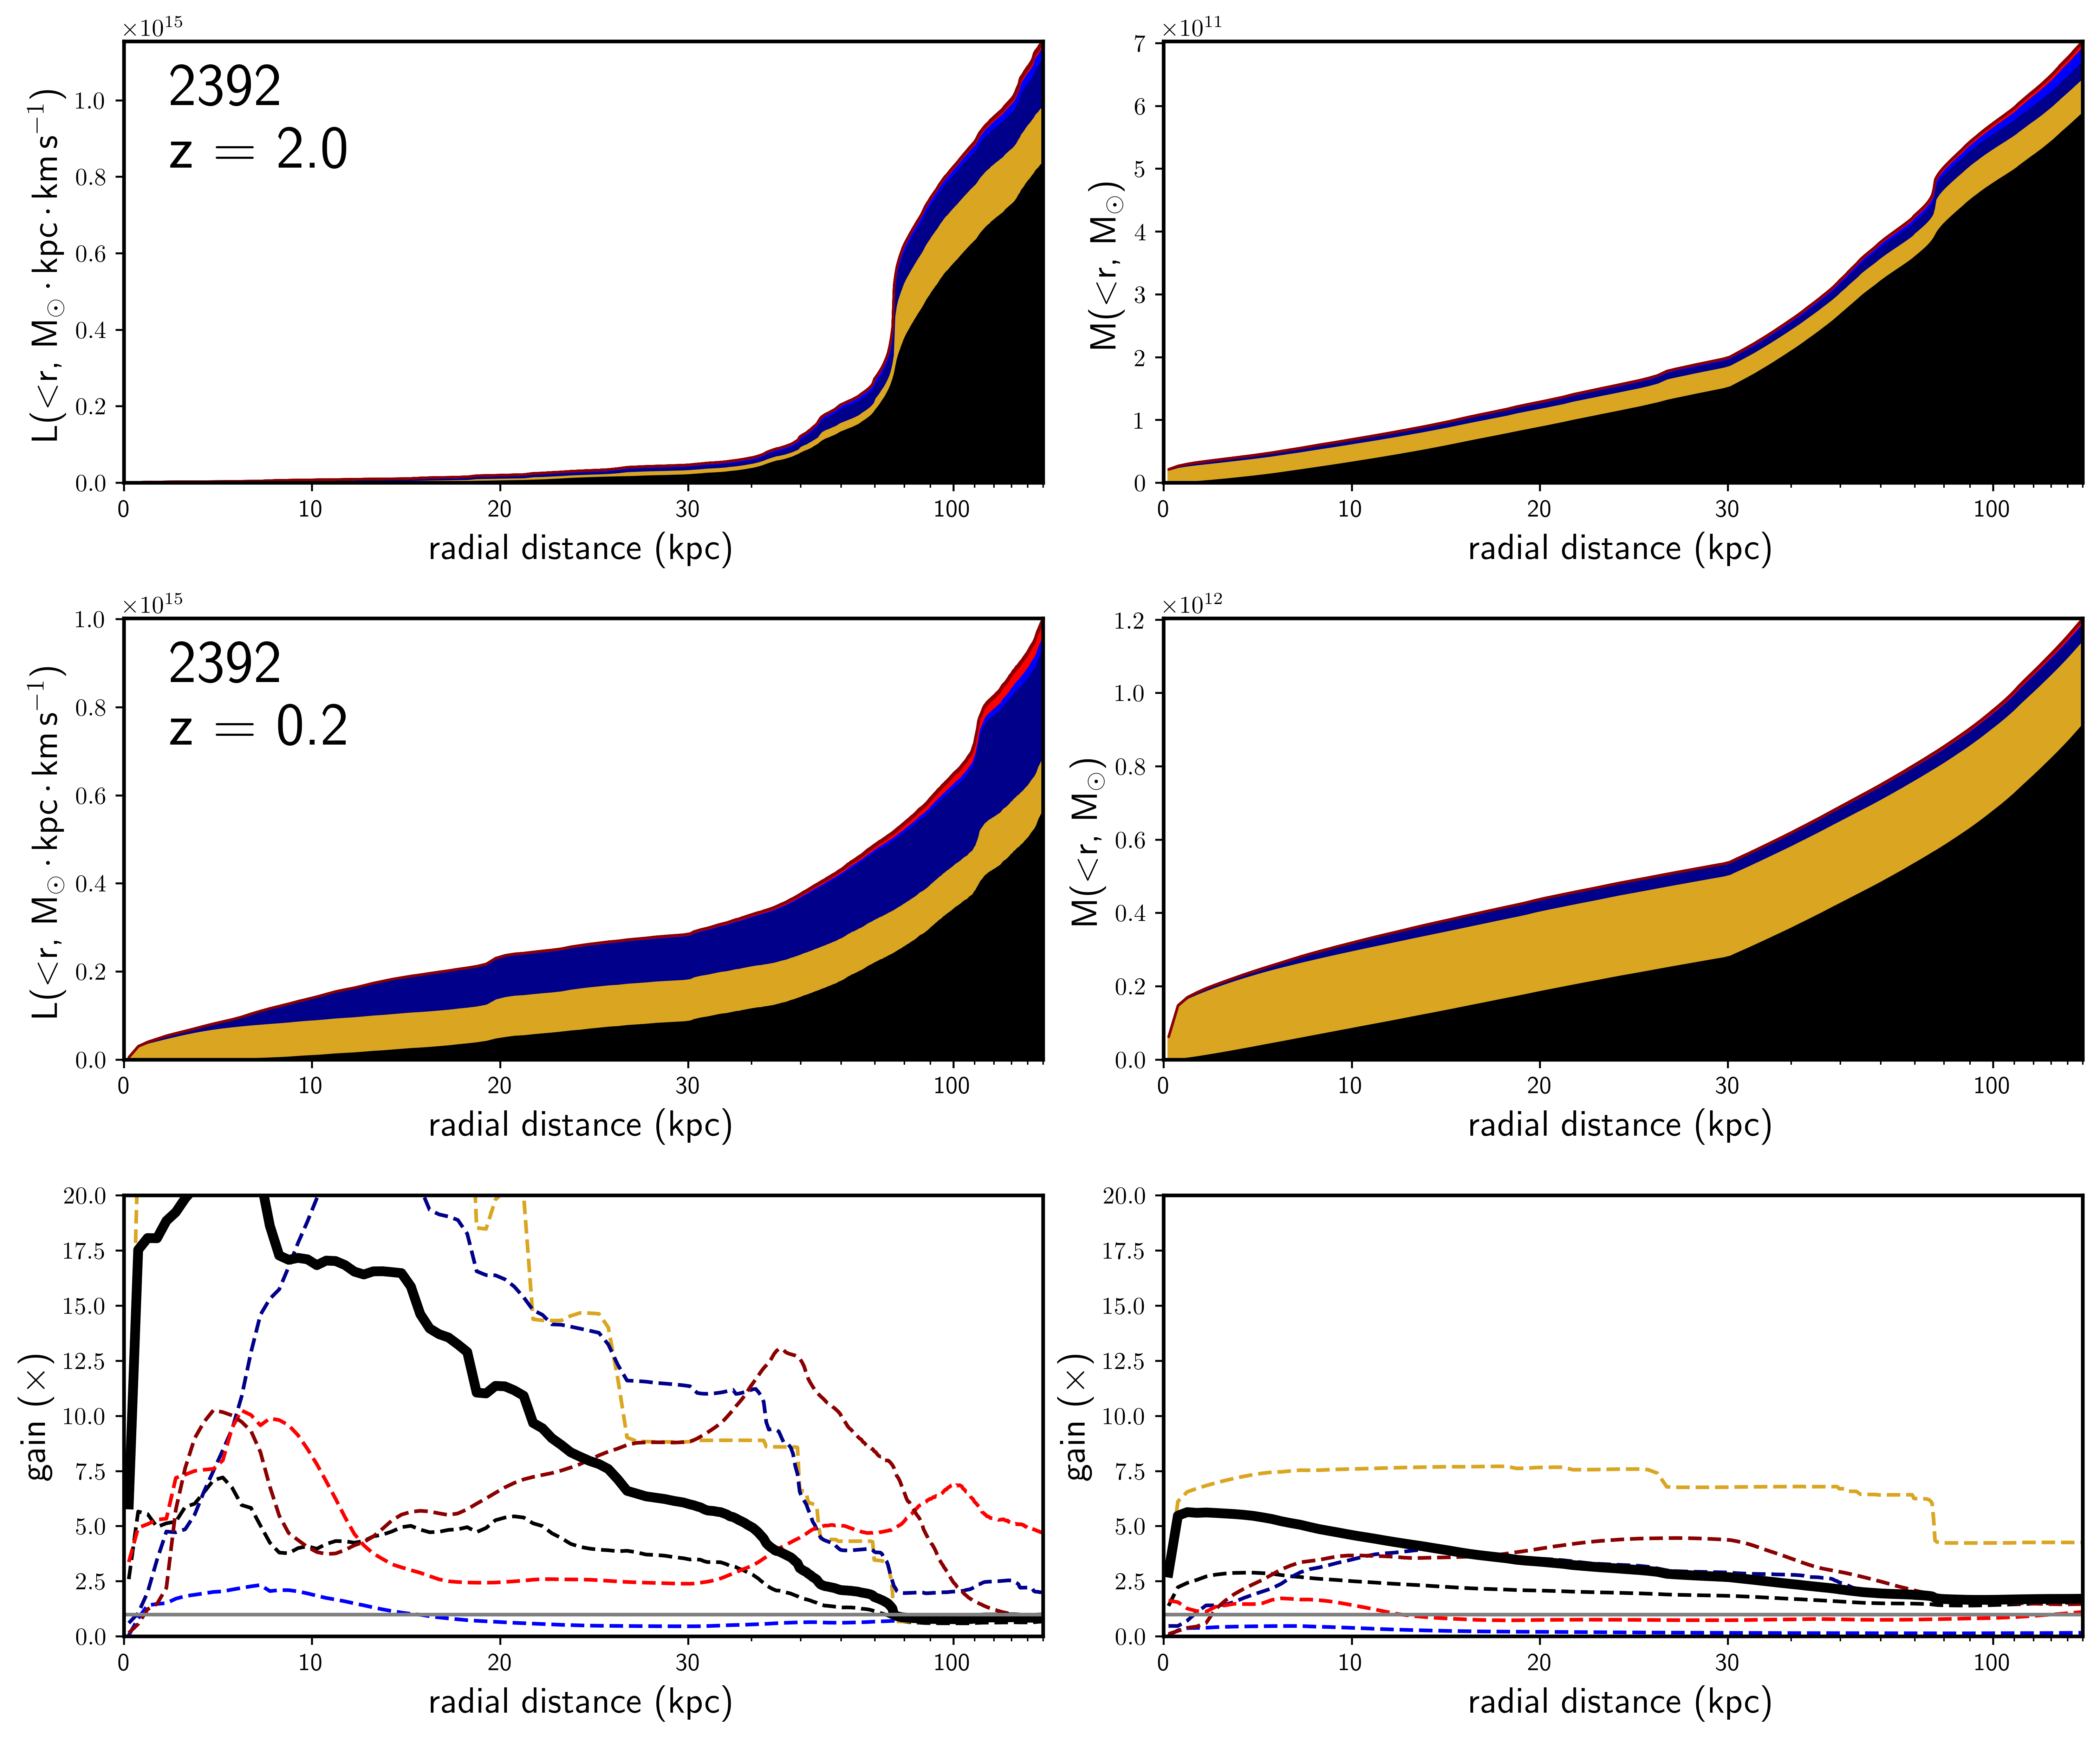

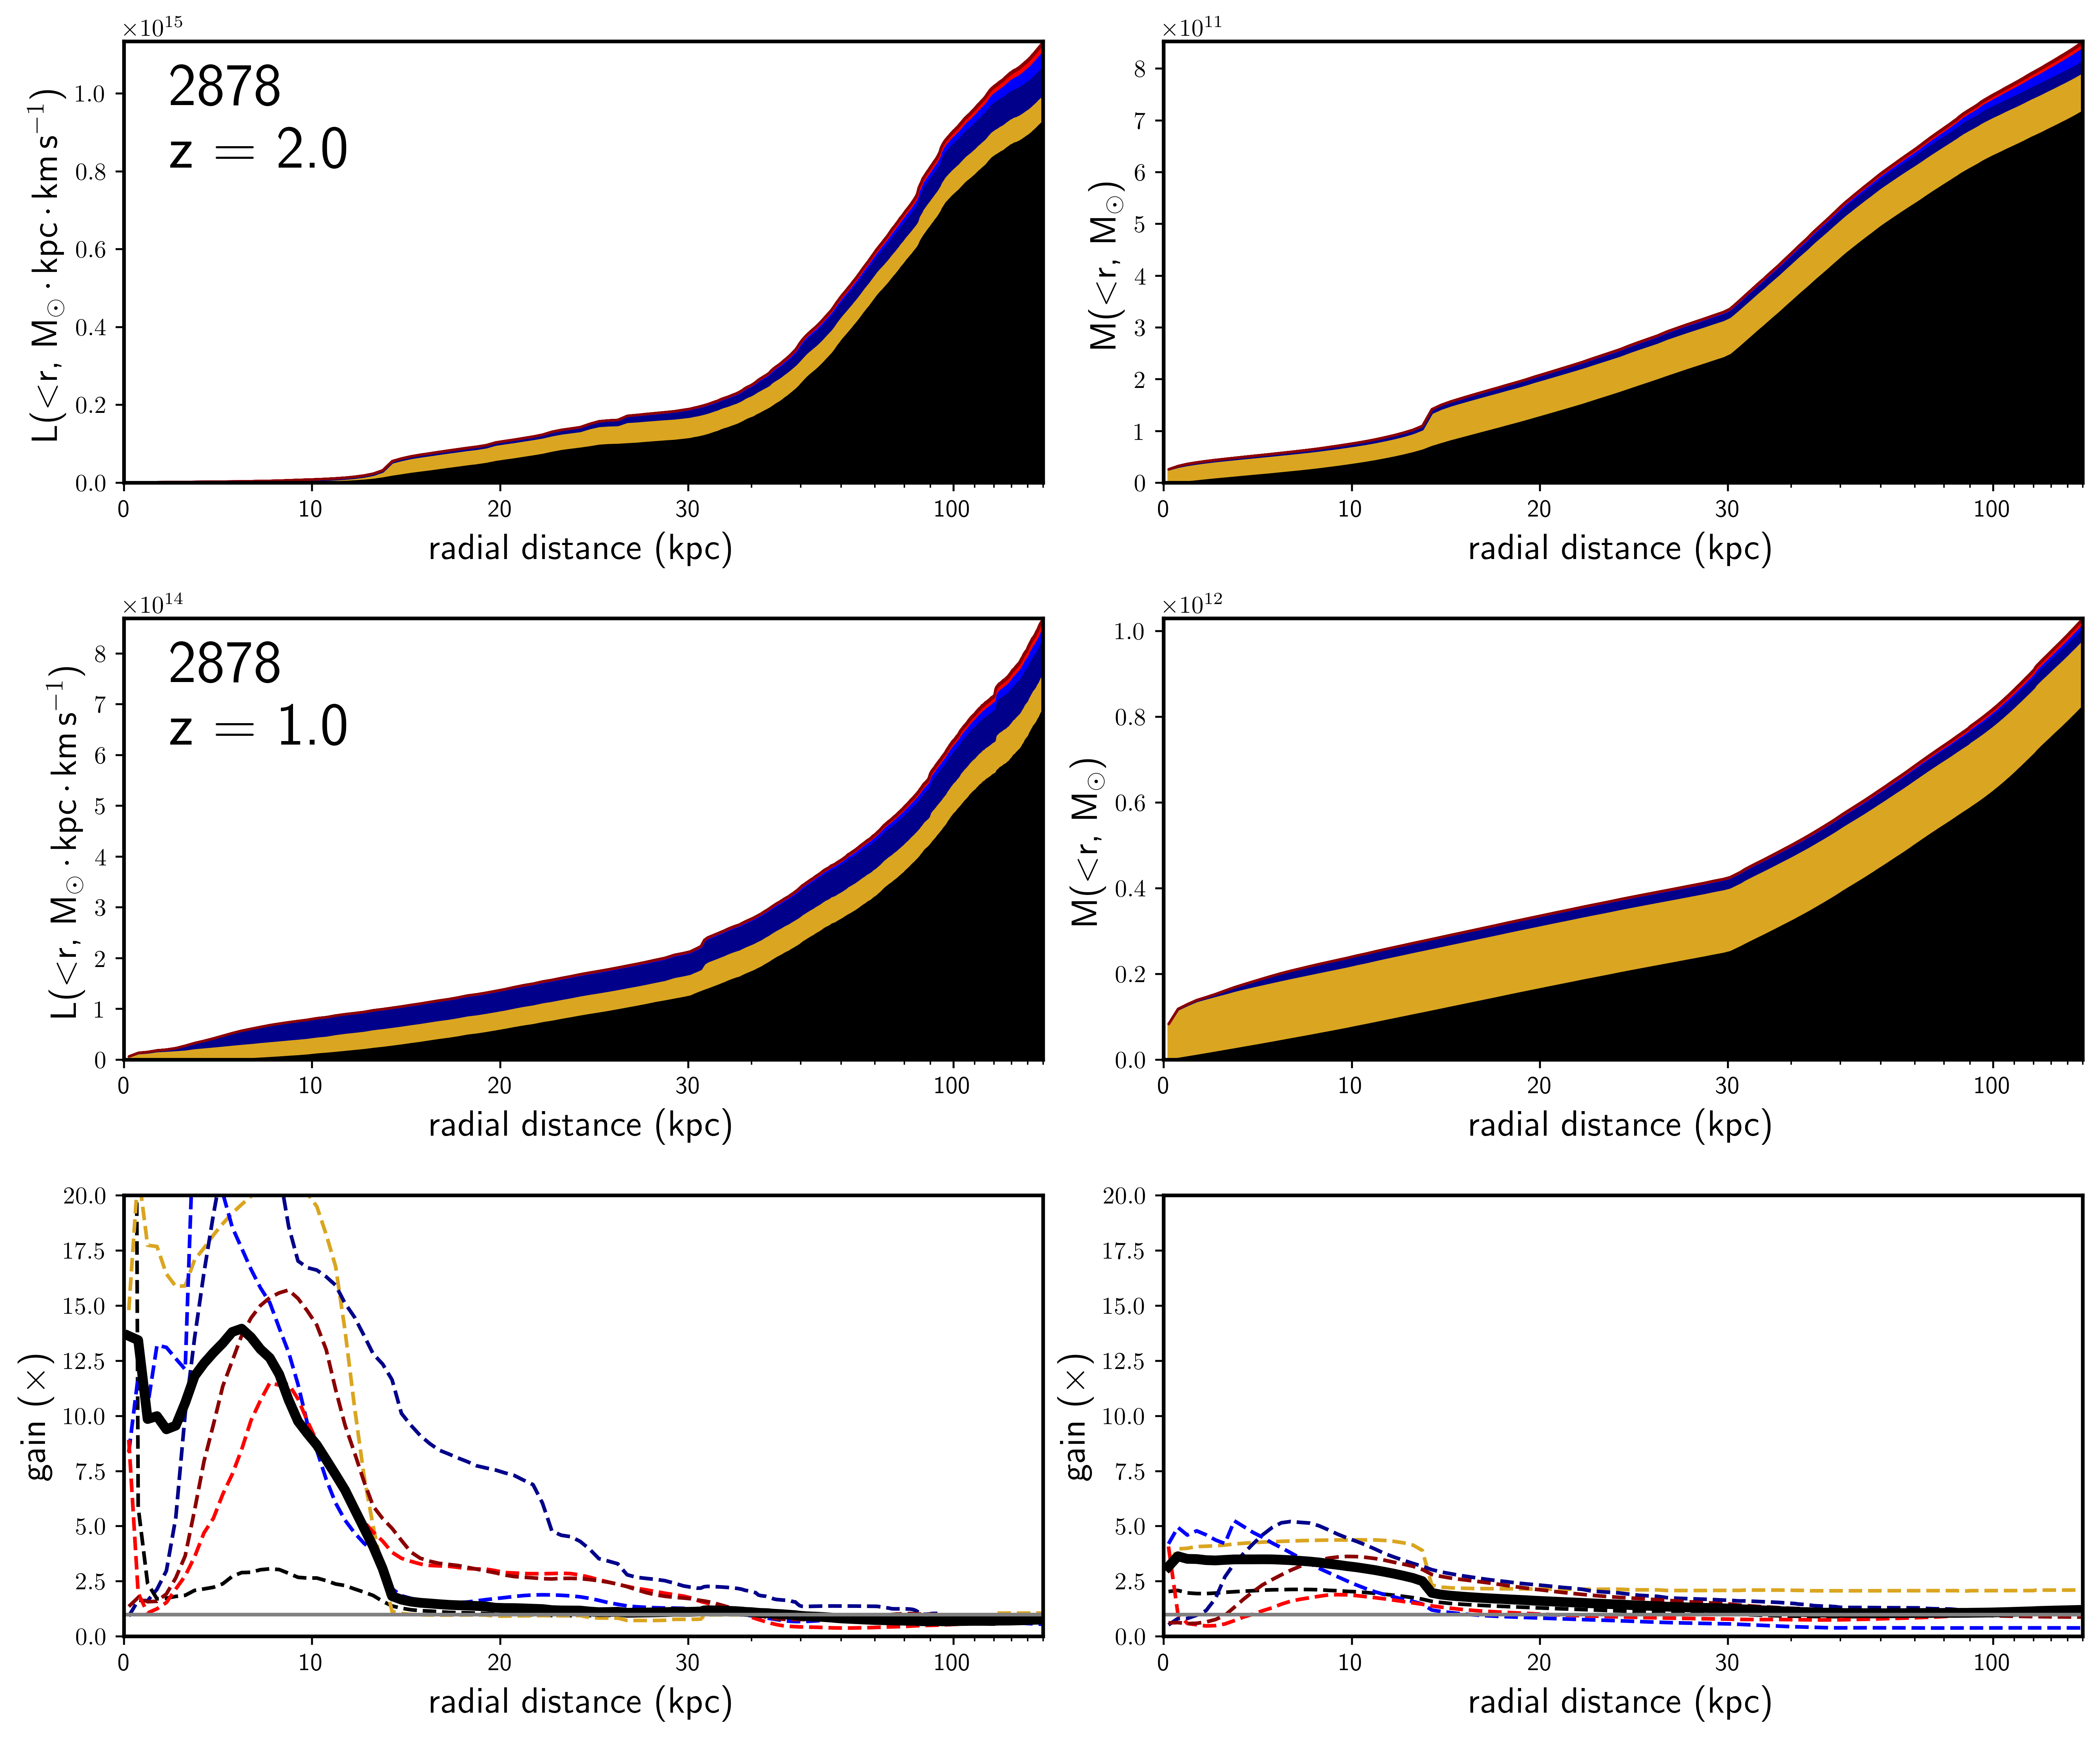

In [81]:
logscale = False
for halo in ['5016', '8508', '5036', '4123', '2392', '2878']:
    #profdir = '/Users/rsimons/Dropbox/foggie/angular_momentum/profiles/%s'%halo
    #all_rprof_fname = profdir + '/' + 'all_rprof_%s.npy'%halo

    #all_rprof = np.load(all_rprof_fname, allow_pickle = True)[()]
    all_rprof = all_rprof_halos[halo]
    DDs       = np.array([int(DD) for DD in list(all_rprof.keys())])
    DDmax     = DDs[-1]
    DD_z = np.load('/Users/rsimons/Dropbox/foggie/catalogs/DD_redshift.npy', allow_pickle = True)[()]
    DD_z = DD_z[halo]
    if halo == '8508': DDmin = 487
    else: DDmin = 581
    fig, axes_all = plt.subplots(3,2, figsize = (12,10), facecolor = 'white')
    mtypes = [('dm', 'black'), ('stars', 'goldenrod'), ('cold', 'darkblue'),
              ('warm', 'blue'),  ('warmhot', 'red'), ('hot', 'darkred')]
    
    DDs_use = [DDmin, DDmax]

    L_accum_all = {}
    M_accum_all = {}
    for (mtype, clr) in mtypes:
        L_accum_all[mtype] = {}
        M_accum_all[mtype] = {}
    for d, DD in enumerate(DDs_use):
        axes = axes_all[d]
        
        y1L = np.zeros(499)
        y1M = np.zeros(499)
        for (mtype, clr) in mtypes:
                rprof     = all_rprof['%.4i'%DD][mtype]  
                r = rprof['r']
                L_accum = cumsum(np.sqrt(rprof['Lx']**2 + rprof['Ly']**2 + rprof['Lz']**2))
                M_accum = cumsum(rprof['mass'])

                L_accum = L_accum.value * u.g * u.cm**2 * u.s**-1
                M_accum = M_accum.value * u.Msun
                L_accum_all[mtype][DD] = L_accum.to('Msun * kpc * km/s').value
                M_accum_all[mtype][DD] = M_accum.to('Msun').value
                lbl_name = get_lbl_name(mtype)
                y2L = y1L + L_accum_all[mtype][DD]
                axes[0].fill_between(r, y1 = y1L, y2 = y2L, label = lbl_name, color = clr)
                y1L = y2L
                y2M = y1M + M_accum_all[mtype][DD]
                axes[1].fill_between(r, y1 = y1M, y2 = y2M, label = lbl_name, color = clr)
                y1M = y2M
        redshift = DD_z['DD%.4i'%DD]
        for a, ax in enumerate(axes):
            if logscale: 
                ax.set_yscale('log')
                
            ax.set_xscale('symlog', linthreshx=30)
            ax.set_xticks(np.arange(0, 300, 10), minor = True)
            ax.set_xticks([0, 10, 20, 30, 100, 200], minor = False)
            ax.set_xticklabels(['0', '10', '20', '30', '100', '200'])
            ax.set_xlabel('radial distance (kpc)')            
            ax.set_xlim(0, 150)
            if a == 0:
                ax.annotate(halo +'\nz = %.1f'%float(redshift), (0.05, 0.95), fontsize = 25,
                            ha = 'left', va = 'top', xycoords = 'axes fraction', color = 'black')
            ax.set_ylim(0, ax.get_ylim()[1])
            #ax.legend(loc = 2)
        ymx_L = y2L[argmin(abs(r.value-150))]
        ymx_M = y2M[argmin(abs(r.value-150))]

        axes[0].set_ylim(0, ymx_L)
        axes[1].set_ylim(0, ymx_M)
        axes[0].set_ylabel('L($<$r, M$_{\odot}$\,$\cdot$\,kpc\,$\cdot$\,km\,s$^{-1}$)')
        axes[1].set_ylabel('M($<$r, M$_{\odot}$)')
        handles, labels = ax.get_legend_handles_labels()
    L_tot_0 = 0
    L_tot_1 = 0
    M_tot_0 = 0
    M_tot_1 = 0
    
    for (mtype, clr) in mtypes:
        axes_all[2,0].plot(r, L_accum_all[mtype][DDmax]/L_accum_all[mtype][DDmin], '--', color = clr)
        axes_all[2,1].plot(r, M_accum_all[mtype][DDmax]/M_accum_all[mtype][DDmin], '--', color = clr)
        L_tot_0 +=  L_accum_all[mtype][DDmax]
        L_tot_1 +=  L_accum_all[mtype][DDmin]
        M_tot_0 +=  M_accum_all[mtype][DDmax]
        M_tot_1 +=  M_accum_all[mtype][DDmin]
        
        
    axes_all[2,0].plot(r, L_tot_0/L_tot_1, '-', color = 'black', linewidth = 4)
    axes_all[2,1].plot(r, M_tot_0/M_tot_1, '-', color = 'black', linewidth = 4)
            
    for ax in axes_all[2]:

        #ax.set_yscale('log')
        ax.set_xscale('symlog', linthreshx=30)
        ax.set_xticks(np.arange(0, 300, 10), minor = True)
        ax.set_xticks([0, 10, 20, 30, 100, 200], minor = False)
        ax.set_xticklabels(['0', '10', '20', '30', '100', '200'])
        ax.set_xlabel('radial distance (kpc)')            
        ax.set_xlim(0, 150)
        ax.set_ylabel(r'gain ($\times$)')
        ax.set_ylim(0., 20)
        ax.axhline(y = 1, color = 'grey')
    #for d in np.arange(2): axes_all[0, d].set_ylim(0, axes_all[1, d].get_ylim()[1])
        
    fig.tight_layout()
    fig.set_dpi(500)
    fig.savefig('/Users/rsimons/Dropbox/foggie/angular_momentum/figures/rprof/%s_LMprof_wdm.png'%(halo))
        
        
        
        
        

In [35]:
y2M[-1]/(1.e11)

1.6877895610141886

unyt_quantity(149.75, 'kpc')